- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

## Chapter 9 - Hierarchical Models

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from IPython.display import Image
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_rows', 45)

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

### 9.2.4 - Example: Therapeutic touch

In [2]:
df = pd.read_csv('data/TherapeuticTouchData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null object
dtypes: int64(1), object(1)
memory usage: 4.5+ KB


#### Figure 9.9

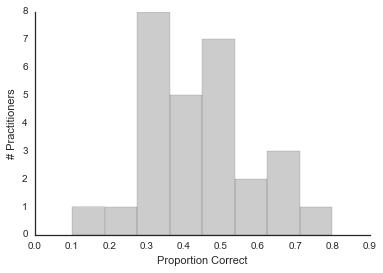

In [3]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

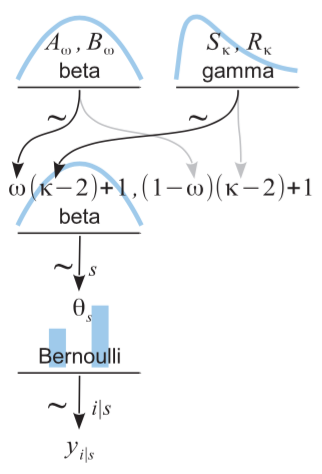

In [4]:
Image('images/fig9_7.png', width=250)

In [5]:
le = preprocessing.LabelEncoder()

practitioner_idx = le.fit_transform(df.s)
practitioner_codes = le.classes_
n_practitioners = len(le.classes_)

with pmc.Model() as hierarchical_model:
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2

    theta = pmc.Beta('theta', omega*(kappa-2)+1, (1-omega)*(kappa-2)+1, shape=n_practitioners)
    
    y = pmc.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [6]:
with hierarchical_model:
    step = pmc.NUTS()
     
    trace = pmc.sample(20000, step)

 [-----------------100%-----------------] 20000 of 20000 complete in 135.4 sec

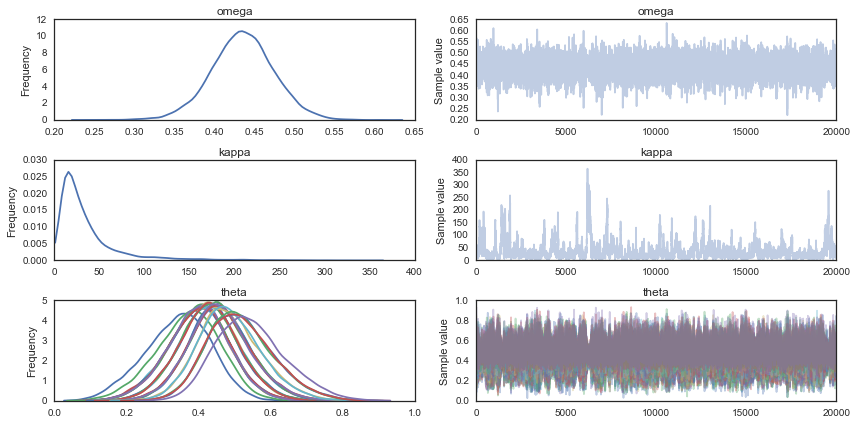

In [7]:
pmc.traceplot(trace);

In [8]:
pmc.df_summary(trace)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

                mean         sd  mc_error   hpd_2.5    hpd_97.5
omega       0.434933   0.039633  0.000467  0.355450    0.512080
kappa      35.271312  35.639119  2.214640  1.197587  108.032299
theta__0    0.342290   0.091987  0.002645  0.150423    0.507222
theta__1    0.371055   0.090557  0.001872  0.183232    0.537002
theta__2    0.399814   0.088126  0.001235  0.221116    0.573265
theta__3    0.400188   0.086422  0.001254  0.227957    0.568121
theta__4    0.400147   0.086636  0.001217  0.231894    0.574802
theta__5    0.400013   0.087212  0.001235  0.230679    0.575599
theta__6    0.399840   0.088260  0.001178  0.226446    0.576769
theta__7    0.400642   0.085912  0.001182  0.226203    0.566978
theta__8    0.400541   0.087585  0.001164  0.217930    0.565804
theta__9    0.399847   0.085730  0.001153  0.223409    0.564929
theta__10   0.429439   0.085296  0.000643  0.257557    0.594635
theta__11   0.429833   0.086537  0.000639  0.252631    0.596678
theta__12   0.428900   0.086453  0.00065

#### Marginal posterior distributions

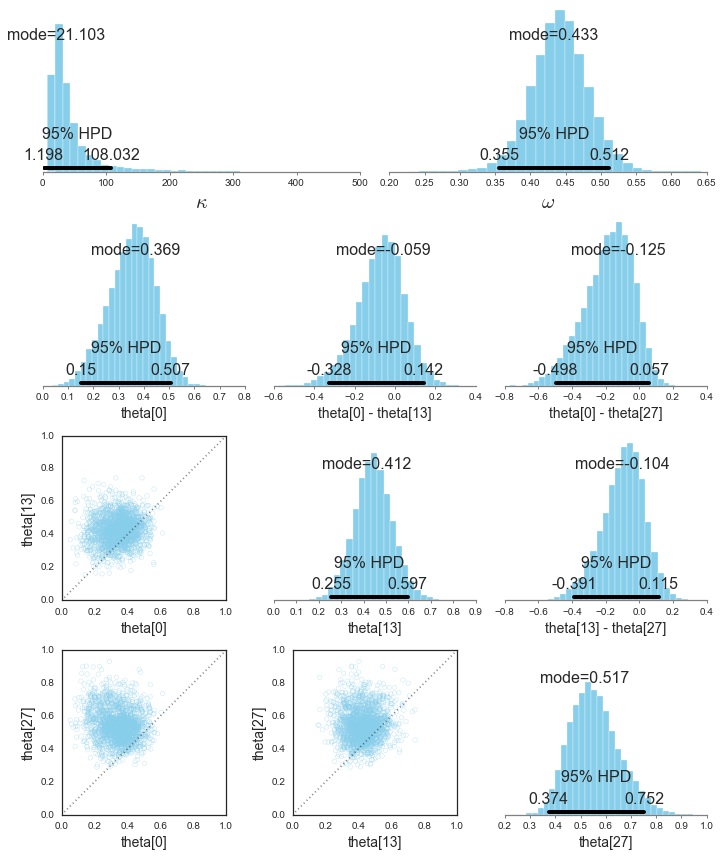

In [9]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

font_d = {'size':14}

# kappa posterior plot
pmc.plot_posterior(trace['kappa'], point_estimate='mode', ax=ax1, color=color)
ax1.set(xlim=(0,500))
ax1.set_xlabel('$\kappa$', fontdict={'size':20, 'weight':'bold'})

# omega posterior plot
pmc.plot_posterior(trace['omega'], point_estimate='mode', ax=ax2, color=color)
ax2.set_xlabel('$\omega$', fontdict={'size':20, 'weight':'bold'})

# theta posterior plots
pmc.plot_posterior(trace['theta'][:,0], point_estimate='mode', ax=ax3, color=color)
ax3.set_xlabel('theta[0]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13], point_estimate='mode', ax=ax7, color=color)
ax7.set_xlabel('theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,27], point_estimate='mode', ax=ax11, color=color)
ax11.set_xlabel('theta[27]', fontdict=font_d)

# theta scatter plots
ax6.scatter(trace['theta'][::10,0], trace['theta'][::10,13], alpha=0.75, color=color, facecolor='none')
ax6.plot([0, 1], [0, 1], ':k', transform=ax6.transAxes, alpha=0.5)
ax6.set_xlabel('theta[0]', fontdict=font_d)
ax6.set_ylabel('theta[13]', fontdict=font_d)

ax9.scatter(trace['theta'][::10,0], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax9.plot([0, 1], [0, 1], ':k', transform=ax9.transAxes, alpha=0.5)
ax9.set_xlabel('theta[0]', fontdict=font_d)
ax9.set_ylabel('theta[27]', fontdict=font_d)

ax10.scatter(trace['theta'][::10,13], trace['theta'][::10,27], alpha=0.75, color=color, facecolor='none')
ax10.plot([0, 1], [0, 1], ':k', transform=ax10.transAxes, alpha=0.5)
ax10.set_xlabel('theta[13]', fontdict=font_d)
ax10.set_ylabel('theta[27]', fontdict=font_d)

for ax in [ax6, ax9, ax10]:
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal') 
    
# theta posterior differences plots
pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,14], point_estimate='mode', ax=ax4, color=color)
ax4.set_xlabel('theta[0] - theta[13]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,0]-trace['theta'][:,27], point_estimate='mode', ax=ax5, color=color)
ax5.set_xlabel('theta[0] - theta[27]', fontdict=font_d)

pmc.plot_posterior(trace['theta'][:,13]-trace['theta'][:,27], point_estimate='mode', ax=ax8, color=color)
ax8.set_xlabel('theta[13] - theta[27]', fontdict=font_d)

plt.tight_layout();

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

In [10]:
with pmc.Model() as unpooled_model:
    
    theta = pmc.Beta('theta', 1, 1, shape=n_practitioners)
        
    y = pmc.Bernoulli('y', theta[practitioner_idx], observed=df.y)        

Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [11]:
with unpooled_model:
    step = pmc.NUTS()
     
    unpooled_trace = pmc.sample(20000, step)

 [-----------------100%-----------------] 20000 of 20000 complete in 15.4 sec

Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [12]:
df_shrinkage = (pd.concat([pmc.df_summary(unpooled_trace).iloc[:,0], pmc.df_summary(trace).iloc[2:,0]], axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

      theta     Model     value
0  theta__0  unpooled  0.165830
1  theta__1  unpooled  0.250836
2  theta__2  unpooled  0.333205
3  theta__3  unpooled  0.332302
4  theta__4  unpooled  0.333993

The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

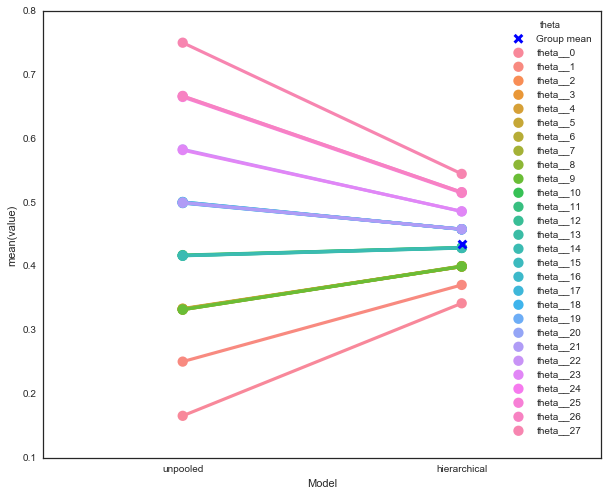

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(1, pmc.df_summary(trace).iloc[0,0], s=60, marker='x', linewidths=3, zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

### 9.5.1 - Example: Baseball batting abilities by position

In [14]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3])
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null object
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: int64(2), object(2)
memory usage: 29.7+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [15]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

           Player      PriPos  Hits  AtBats     BatAv
0   Fernando Abad     Pitcher     1       7  0.142857
1     Bobby Abreu  Left Field    53     219  0.242009
2      Tony Abreu    2nd Base    18      70  0.257143
3   Dustin Ackley    2nd Base   137     607  0.225700
4      Matt Adams    1st Base    21      86  0.244186
5   Nathan Adcock     Pitcher     0       1  0.000000
6  Jeremy Affeldt     Pitcher     0       1  0.000000
7   Brandon Allen    1st Base     2      20  0.100000
8   Yonder Alonso    1st Base   150     549  0.273224
9     Jose Altuve    2nd Base   167     576  0.289931

In [16]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

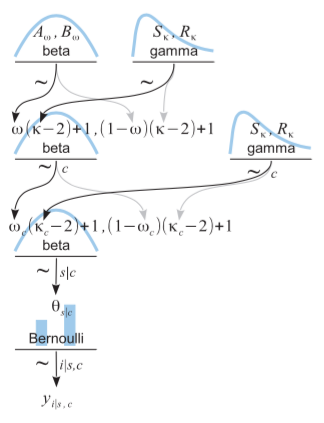

In [17]:
Image('images/fig9_13.png', width=400)

In [24]:
le = preprocessing.LabelEncoder()

# Encode the 9 primary field positions
pripos_idx = le.fit_transform(df2.PriPos)
pripos_codes = le.classes_
n_pripos = len(le.classes_)

# df2 contains one entry per player
players_idx = le.fit_transform(df2.Player)    # Not really needed, since we have 1 record per player
n_players = len(le.classes_)

with pmc.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pmc.Beta('omega', 1, 1)
    kappa = pmc.Gamma('kappa', 0.01, 0.01)+2 
    
    # Parameters for categories (Primary field positions)
    omega_c = pmc.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c = pmc.Gamma('kappa_c',
                        0.01, 0.01,
                        shape = n_pripos)+2
    # Parameter for individual players
    theta = pmc.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1, (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pmc.Binomial('y2', n=df2.AtBats.as_matrix(), p=theta[players_idx], observed=df2.Hits)    

Applied logodds-transform to omega and added transformed omega_logodds_ to model.
Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to omega_c and added transformed omega_c_logodds_ to model.
Applied log-transform to kappa_c and added transformed kappa_c_log_ to model.
Applied logodds-transform to theta and added transformed theta_logodds_ to model.


In [25]:
with hierarchical_model2:
    step = pmc.NUTS()
    trace2 = pmc.sample(20000, step)

 [-----------------100%-----------------] 20000 of 20000 complete in 32643.5 sec

I think the powersaving settings of my computer made it fall asleep during sampling a number of times, making the sampling time look very long! :-)

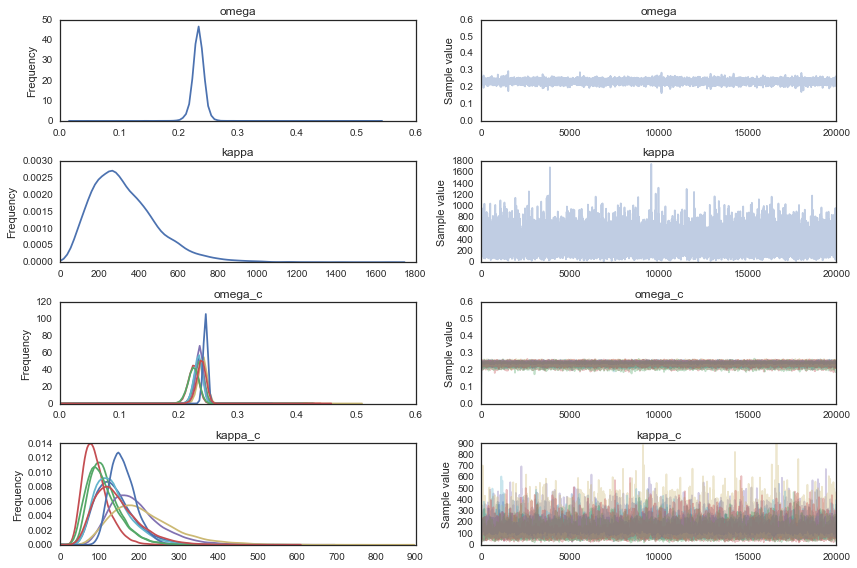

In [26]:
pmc.traceplot(trace2, varnames=['omega', 'kappa', 'omega_c', 'kappa_c']);

In [27]:
pmc.df_summary(trace2)

                  mean          sd  mc_error     hpd_2.5    hpd_97.5
omega         0.233419    0.010254  0.000081    0.213700    0.251410
kappa       326.489588  166.723014  1.511000   55.066564  652.468323
omega_c__0    0.233443    0.008181  0.000110    0.218655    0.247658
omega_c__1    0.234745    0.008408  0.000094    0.219008    0.250077
omega_c__2    0.224866    0.009437  0.000125    0.207632    0.241856
omega_c__3    0.235064    0.006725  0.000108    0.223617    0.247012
omega_c__4    0.240438    0.008082  0.000103    0.226599    0.254534
omega_c__5    0.232841    0.007690  0.000128    0.218937    0.246279
omega_c__6    0.245371    0.005569  0.000095    0.238115    0.252860
omega_c__7    0.224874    0.010142  0.000143    0.206277    0.243014
omega_c__8    0.238192    0.008409  0.000107    0.222948    0.253476
kappa_c__0  141.912000   54.007976  1.229057   55.823299  251.445806
kappa_c__1  115.293505   41.017971  0.770564   49.603749  199.478217
kappa_c__2   90.962448   32.838405

##### Posterior distributions of the omega_c parameters after sampling. Way too similar?!

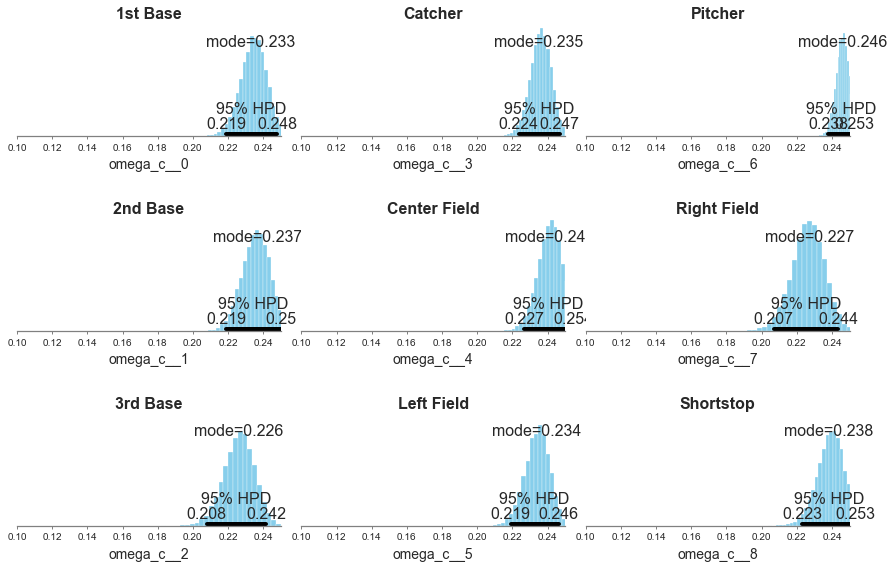

In [28]:
fig, axes = plt.subplots(3,3, figsize=(12,8))
for i, ax in enumerate(axes.T.flatten()):
    pmc.plot_posterior(trace2['omega_c'][100:,i], ax=ax, point_estimate='mode', color='#87ceeb')
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.1,0.25)
plt.tight_layout(h_pad=3)

##### The below image from the book shows the __omega_c__ distributions obtained by JAGS/R

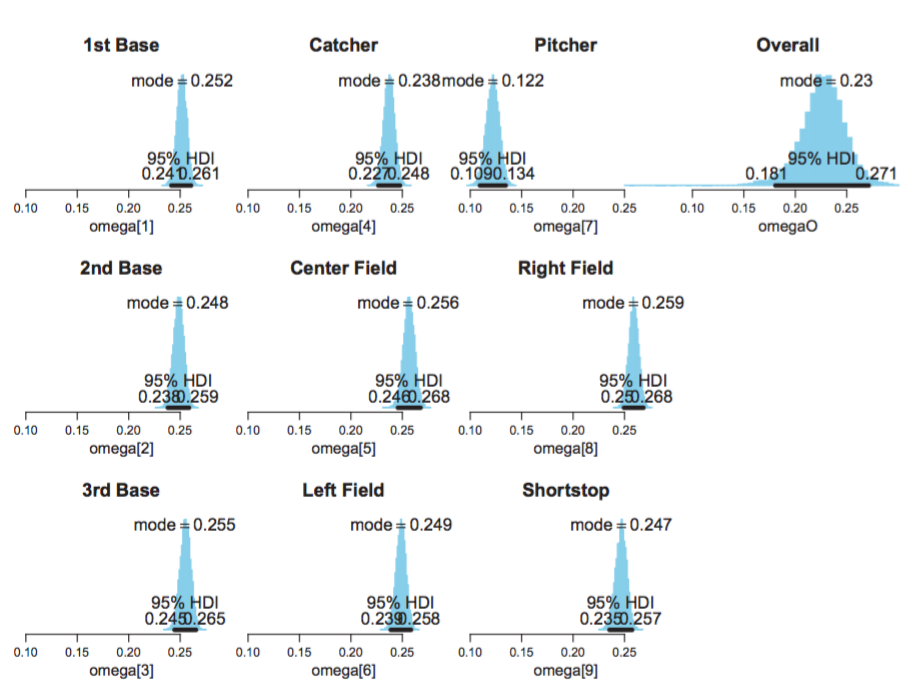

In [29]:
Image('images/fig9_17.png')